# AutoRegressive Integrated Moving Average (ARIMA)

**Importing libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import interpolate
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

## Data Preparation

### Loading Data

In [2]:
df = pd.read_excel("C:/Users/victo/Desktop/Bikehop_daily_sales.xlsx")
df.head()

,date,sales,units,category,product
0,2017-07-01,3399.9900,1,Bikes,Mountain Bikes
1,2017-07-01,699.0982,1,Bikes,Road Bikes
2,2017-07-01,3578.2700,1,Bikes,Road Bikes
3,2017-07-02,3578.2700,1,Bikes,Road Bikes
4,2017-07-02,3578.2700,1,Bikes,Road Bikes


### Drop columns

As in our premises, the prediction needs to be done only taking into account total sales, we will remove the unnecesarry columns

In [3]:
df= df.drop(['units','category','product'],axis=1)
df.head()

,date,sales
0,2017-07-01,3399.9900
1,2017-07-01,699.0982
2,2017-07-01,3578.2700
3,2017-07-02,3578.2700
4,2017-07-02,3578.2700


### Month aggregation

**Our task is to forecast monthly total sales.** Consequently, we need to aggregate our data at the monthly level.

For doing so we will make sure that our date is converted to datetime.

In [4]:
df['date'] = df['date'].dt.year.astype('str') + '-' + df['date'].dt.month.astype('str') + '-01'

df['date'] = pd.to_datetime(df['date'])

df = df.groupby('date').sales.sum().reset_index()

df.head()

,date,sales
0,2017-07-01,6.297580e+05
1,2017-08-01,1.396284e+06
2,2017-09-01,1.746453e+06
3,2017-10-01,2.034580e+05
4,2017-11-01,3.676672e+06


In [5]:
df.set_index('date', inplace=True)
df.head()

,sales
date,
2017-07-01,6.297580e+05
2017-08-01,1.396284e+06
2017-09-01,1.746453e+06
2017-10-01,2.034580e+05
2017-11-01,3.676672e+06


## Convert to time series:

In [6]:
ts = df['sales']
ts.head()

date
2017-07-01    6.297580e+05
2017-08-01    1.396284e+06
2017-09-01    1.746453e+06
2017-10-01    2.034580e+05
2017-11-01    3.676672e+06
Name: sales, dtype: float64

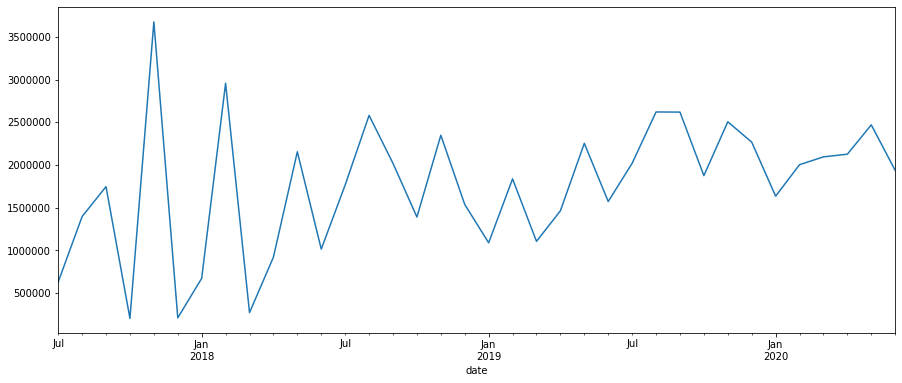

In [7]:
ts.plot();

## Decomposite the model

In [8]:
decomposition = seasonal_decompose(ts)

In [9]:
#Tendencias
trend = decomposition.trend

#Variaciones estacionales
seasonal = decomposition.seasonal

#Variaciones aleatorias
residual = decomposition.resid

**Ploting the decompisiton**

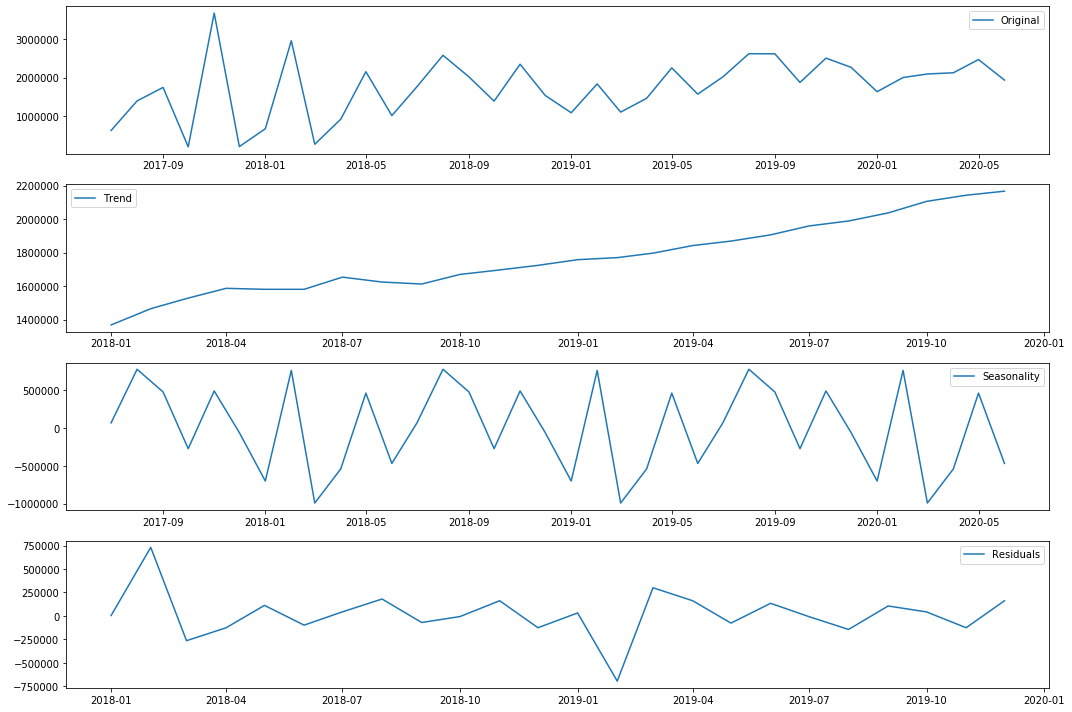

In [10]:
plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')


plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')


plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')

plt.legend(loc='best')
plt.tight_layout()

## Checking for stationarity

In [11]:
#We create a function using the rolling mean
def test_stationarity(timeseries):
    
    #Statistics
    rolstd = timeseries.rolling(12).std()    
    rolmean = timeseries.rolling(12).mean()

    #Plotting rolling statistics
    original = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Print Dickey-Fuller for checking p-value and reject/accept the null hyphotesis:
    print('Results of Dickey-Fuller Test:')
    
    #Using Akaike criterion as quality measure for the number of lags used to find the same correlation.
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)

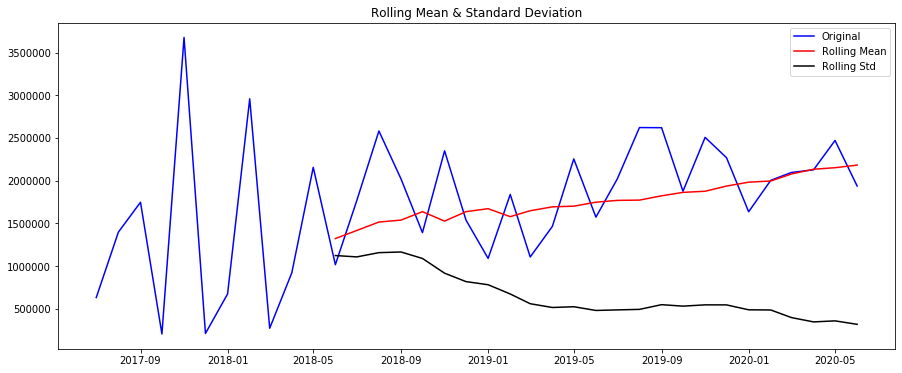

Results of Dickey-Fuller Test:
Test Statistic                 -0.963359
p-value                         0.766393
#Lags Used                      9.000000
Number of Observations Used    26.000000
Critical Value (1%)            -3.711212
Critical Value (5%)            -2.981247
Critical Value (10%)           -2.630095
dtype: float64


In [12]:
test_stationarity(ts)

**As our p-value is higher than 0.05, we know that our data is non-stationary.**

## Making timeseries stationary

### Log

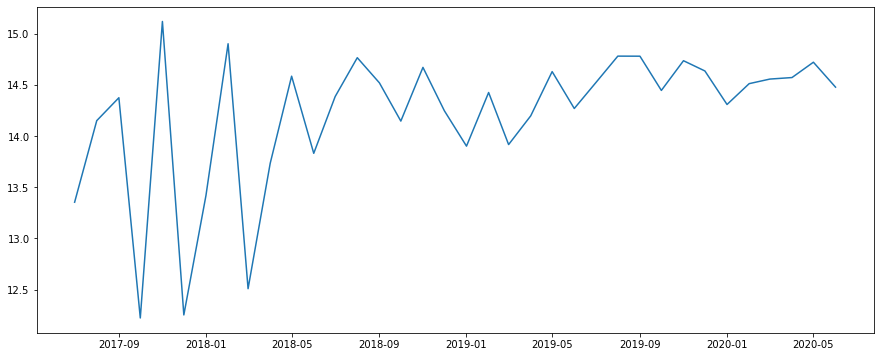

In [13]:
#Converting the dataset to log
ts_log = np.log(ts)
plt.plot(ts_log);

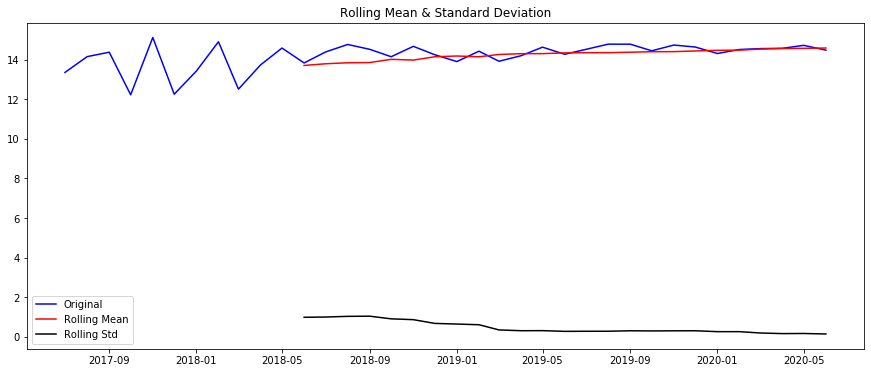

Results of Dickey-Fuller Test:
Test Statistic                 -3.632955
p-value                         0.005161
#Lags Used                      9.000000
Number of Observations Used    26.000000
Critical Value (1%)            -3.711212
Critical Value (5%)            -2.981247
Critical Value (10%)           -2.630095
dtype: float64


In [14]:
#Checking our pvalue again with the function defined previously
test_stationarity(ts_log)

**Our data is now stationary**

Let's try other methods if we have a lower p-value.

### Smoothing

#### Moving average

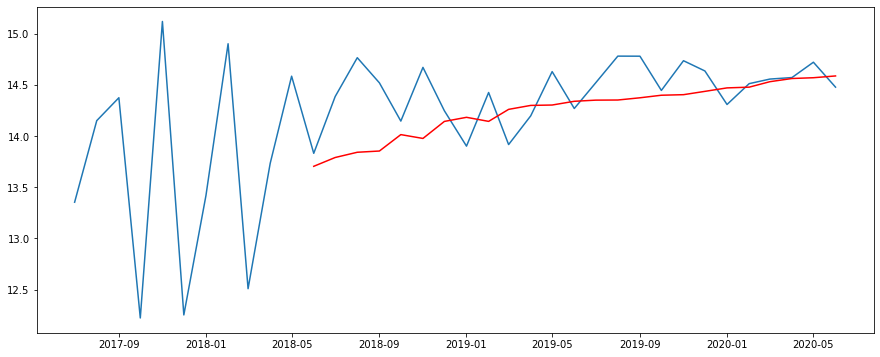

In [15]:
moving_avg = ts_log.rolling(12).mean()

plt.plot(ts_log)

plt.plot(moving_avg, color='red');

In [16]:
ts_log_moving_avg_diff = ts_log - moving_avg

ts_log_moving_avg_diff.head(12)

date
2017-07-01       NaN
2017-08-01       NaN
2017-09-01       NaN
2017-10-01       NaN
2017-11-01       NaN
2017-12-01       NaN
2018-01-01       NaN
2018-02-01       NaN
2018-03-01       NaN
2018-04-01       NaN
2018-05-01       NaN
2018-06-01    0.1268
Name: sales, dtype: float64

In [17]:
ts_log_moving_avg_diff.dropna(inplace=True)

ts_log_moving_avg_diff.head()

date
2018-06-01    0.126800
2018-07-01    0.594749
2018-08-01    0.923013
2018-09-01    0.665384
2018-10-01    0.132095
Name: sales, dtype: float64

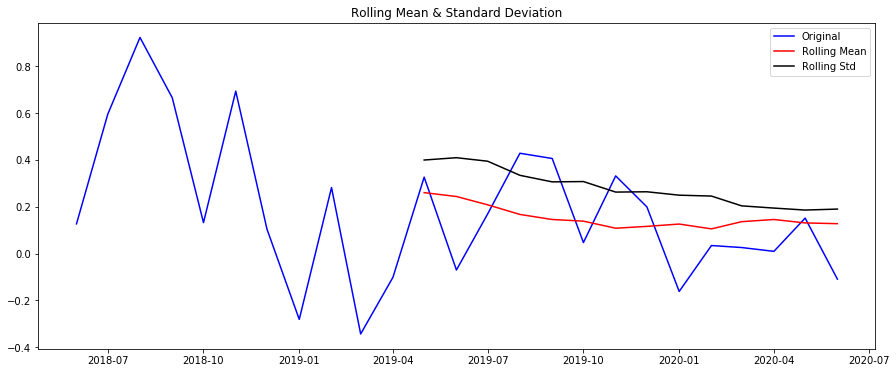

Results of Dickey-Fuller Test:
Test Statistic                 -1.289638
p-value                         0.633899
#Lags Used                      9.000000
Number of Observations Used    15.000000
Critical Value (1%)            -3.964443
Critical Value (5%)            -3.084908
Critical Value (10%)           -2.681814
dtype: float64


In [18]:
test_stationarity(ts_log_moving_avg_diff)

**Our data is non-stationary**

#### Exponentially Weighted Moving Average

The closer the points are to today, the more important they are

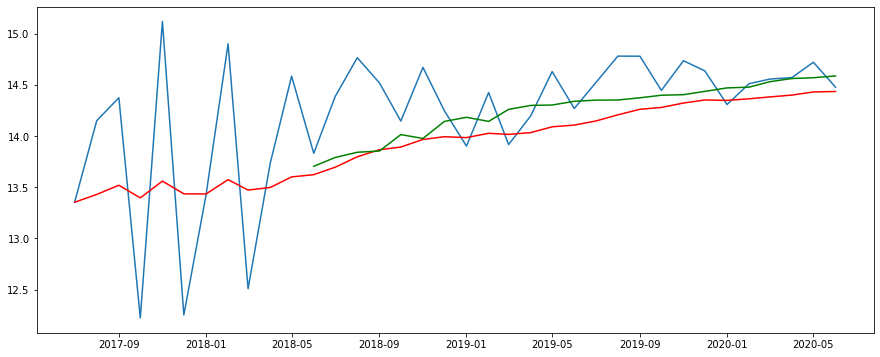

In [19]:
expwighted_avg = ts_log.ewm(span=20,adjust=False).mean()

plt.plot(ts_log)

plt.plot(expwighted_avg, color='red')

plt.plot(moving_avg, color='green');

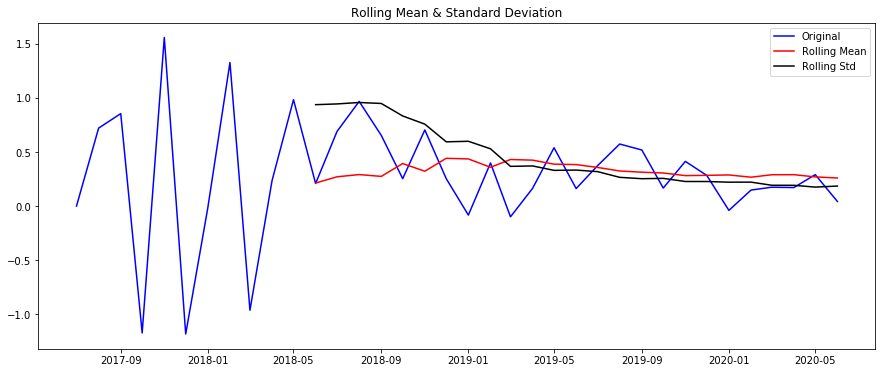

Results of Dickey-Fuller Test:
Test Statistic                 -3.746974
p-value                         0.003499
#Lags Used                      7.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64


In [20]:
ts_log_ewma_diff = ts_log - expwighted_avg

test_stationarity(ts_log_ewma_diff)

**Our data is stationary**

### Differencing

Delete the fluctuation. Replacing each value for the value difference minus the previous value.

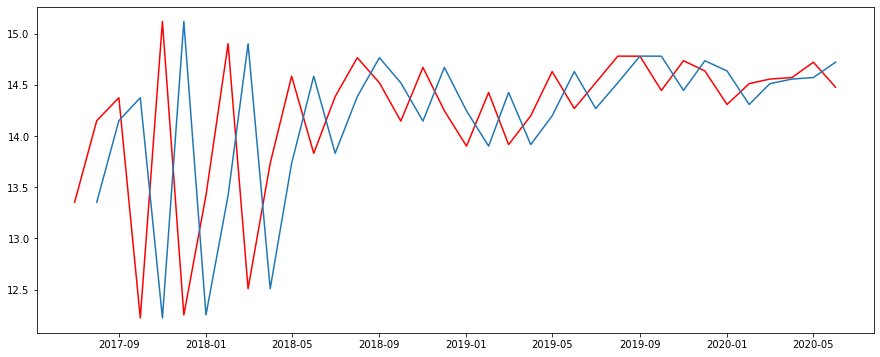

In [21]:
plt.plot(ts_log, color='red')

plt.plot(ts_log.shift());

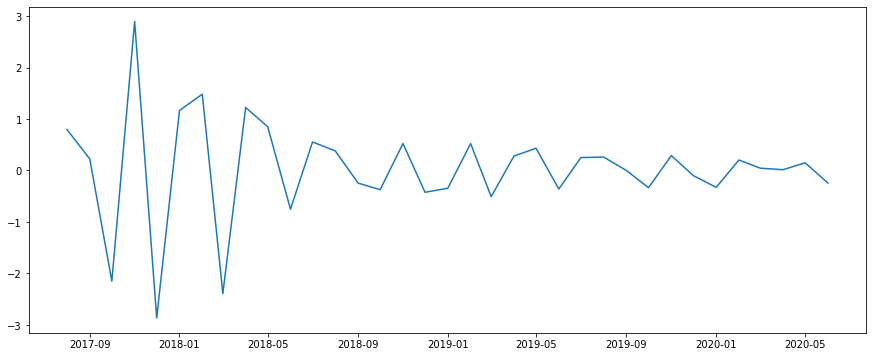

In [22]:
#Taking first difference:

ts_log_diff = ts_log - ts_log.shift()

plt.plot(ts_log_diff);

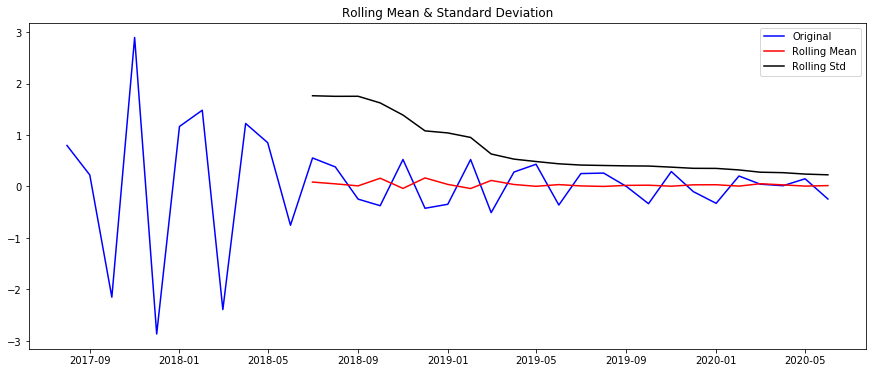

Results of Dickey-Fuller Test:
Test Statistic                 -2.694126
p-value                         0.075060
#Lags Used                     10.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64


In [23]:
ts_log_diff.dropna(inplace=True)

test_stationarity(ts_log_diff)

**Our data is non-stationary**

### Decomposition

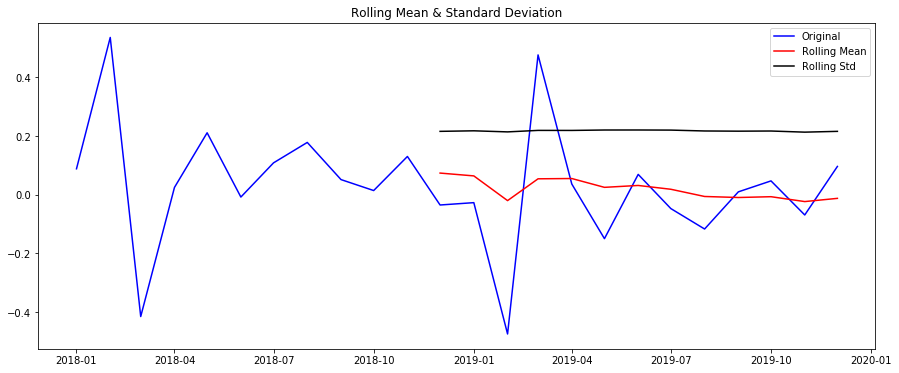

Results of Dickey-Fuller Test:
Test Statistic                -6.656570e+00
p-value                        4.966995e-09
#Lags Used                     1.000000e+00
Number of Observations Used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64


In [24]:
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend

seasonal = decomposition.seasonal

residual = decomposition.resid


ts_log_decompose = residual

ts_log_decompose.dropna(inplace=True)

test_stationarity(ts_log_decompose)

**The decomposition is with the method we have a better p-value**

## Final forecasting

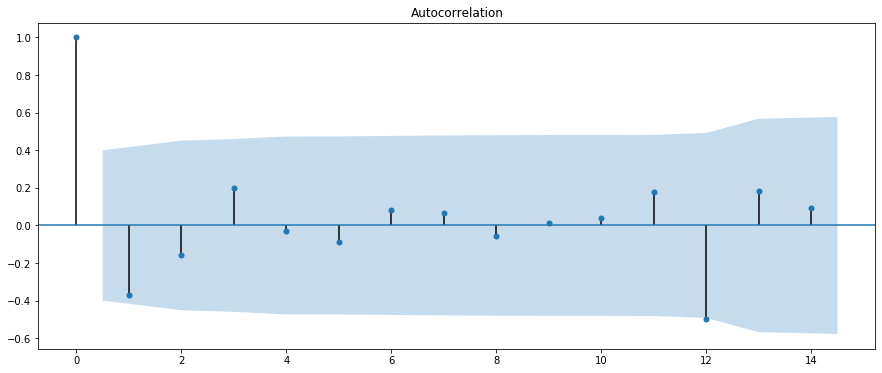

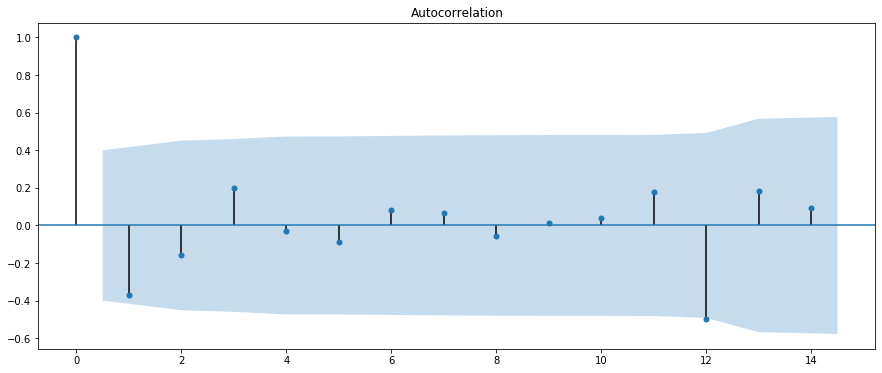

In [25]:
#Autocorrelation for MA Model
plot_acf(ts_log_decompose)

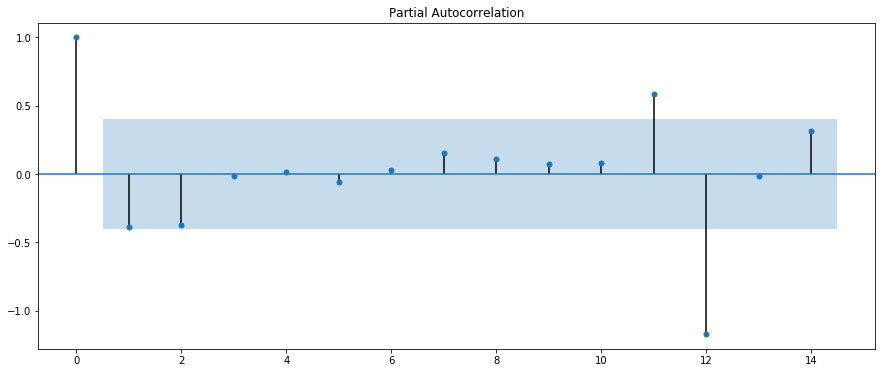

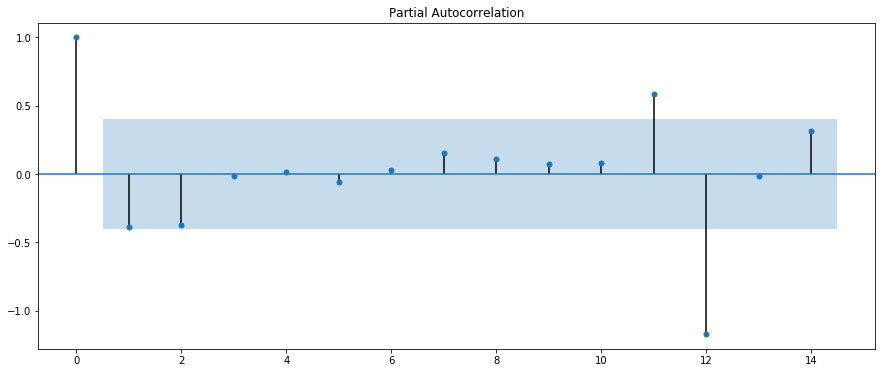

In [26]:
#Autocorrelation for AR Model
plot_pacf(ts_log_decompose)

### AR Model

Next value will depend of the previous ones.

Text(0.5, 1.0, 'RSS: nan')

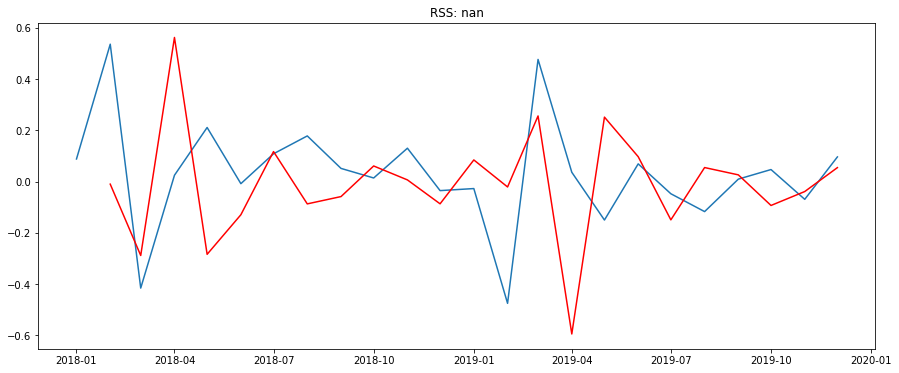

In [27]:
model = ARIMA(ts_log_decompose, order=(1, 1, 0))

results_AR = model.fit(disp=1)

plt.plot(ts_log_decompose)

plt.plot(results_AR.fittedvalues, color='red')

plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_decompose)**2))

### MA Model

Model based on the rolling average. Next value will depend of the mean and the difference of the previous means.

Text(0.5, 1.0, 'RSS: nan')

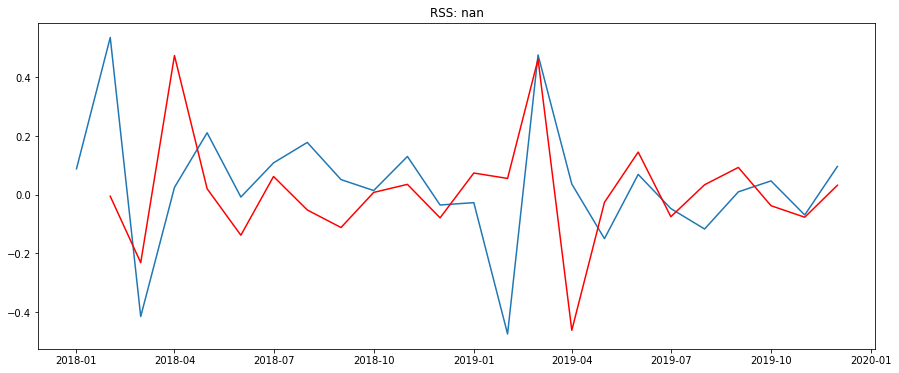

In [28]:
model = ARIMA(ts_log_decompose, order=(0, 1, 1)) 

results_MA = model.fit(disp=1)  

plt.plot(ts_log_decompose)

plt.plot(results_MA.fittedvalues, color='red')

plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_decompose)**2))

### ARIMA

Text(0.5, 1.0, 'RSS: nan')

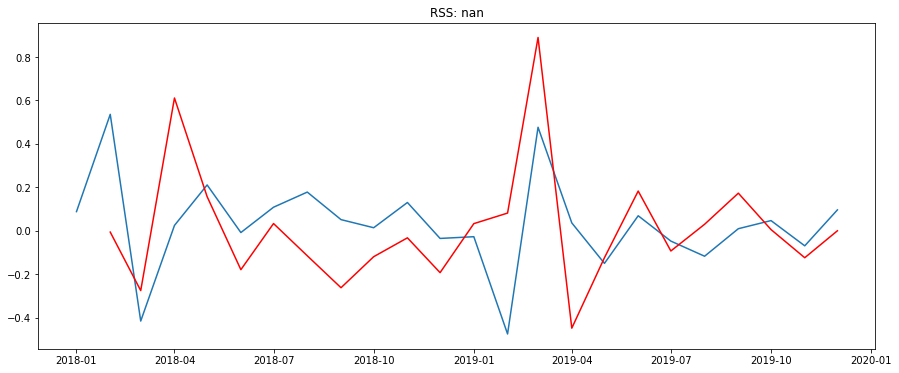

In [29]:
model = ARIMA(ts_log_decompose, order=(2, 1, 2))  

results_ARIMA = model.fit(disp=1)  

plt.plot(ts_log_decompose)

plt.plot(results_ARIMA.fittedvalues, color='red')

plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_decompose)**2))

## Convert to original scale

**Get fitted values**

In [30]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

predictions_ARIMA_diff.head()

date
2018-02-01   -0.006032
2018-03-01   -0.275330
2018-04-01    0.611146
2018-05-01    0.157102
2018-06-01   -0.179024
dtype: float64

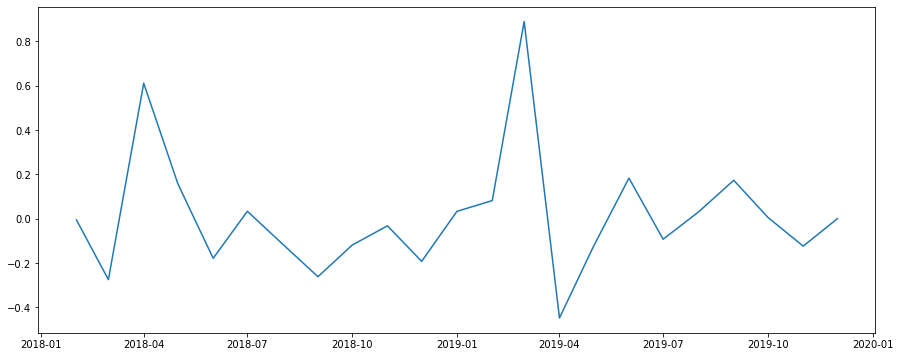

In [31]:
plt.plot(predictions_ARIMA_diff);

**Get cumulative sum of fitted values**

In [32]:
predictions_ARIMA_diff_cumsum = (predictions_ARIMA_diff).cumsum() + moving_avg

predictions_ARIMA_diff_cumsum.head()

date
2017-07-01   NaN
2017-08-01   NaN
2017-09-01   NaN
2017-10-01   NaN
2017-11-01   NaN
dtype: float64

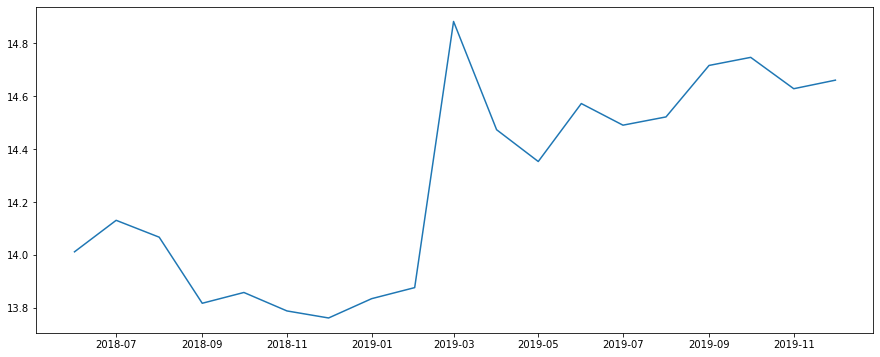

In [33]:
plt.plot(predictions_ARIMA_diff_cumsum);

## Restore base level

In [34]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)

predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

predictions_ARIMA_log.head()

date
2017-07-01    13.353091
2017-08-01    13.353091
2017-09-01    13.353091
2017-10-01    13.353091
2017-11-01    13.353091
dtype: float64

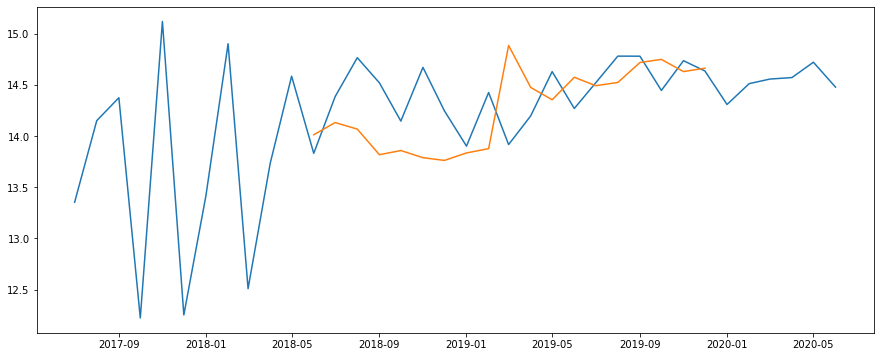

In [35]:
plt.plot(ts_log)

plt.plot(predictions_ARIMA_diff_cumsum);

**Get exponential**

Text(0.5, 1.0, 'RMSE: nan')

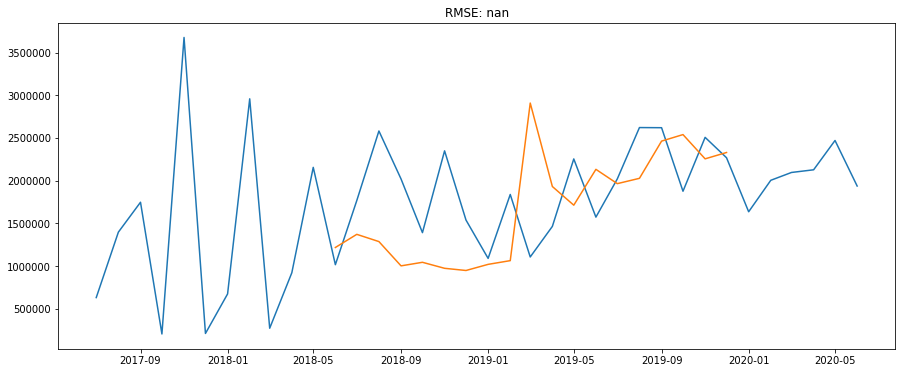

In [36]:
predictions_ARIMA = np.exp(predictions_ARIMA_diff_cumsum) 

plt.plot(ts)

plt.plot(predictions_ARIMA)

plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

# Sarimax

In [37]:
#p: number of autoregressive terms (AR); how many points I want to look back
#d: differencing, 1 is the standard
#q: number of errors that I want to look back
#Normally p & q are calculate through ACF, but you can also do a grid search for Sarimax.

p = d = q = range(1, 3)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


**Grid Search**

In [38]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=False,
                                            freq='MS')

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as e:
            print(e)
            continue

ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:675.9794293292267
ARIMA(1, 1, 1)x(1, 1, 2, 12) - AIC:677.0730702727574
ARIMA(1, 1, 1)x(1, 2, 1, 12) - AIC:326.94304190781304
ARIMA(1, 1, 1)x(1, 2, 2, 12) - AIC:328.7903128823552
ARIMA(1, 1, 1)x(2, 1, 1, 12) - AIC:674.8873054298372
ARIMA(1, 1, 1)x(2, 1, 2, 12) - AIC:676.8872944646456
ARIMA(1, 1, 1)x(2, 2, 1, 12) - AIC:327.2145391382821
ARIMA(1, 1, 1)x(2, 2, 2, 12) - AIC:329.2145843568047
ARIMA(1, 1, 2)x(1, 1, 1, 12) - AIC:677.0075259848046
ARIMA(1, 1, 2)x(1, 1, 2, 12) - AIC:677.9217146564017
ARIMA(1, 1, 2)x(1, 2, 1, 12) - AIC:320.4701067268951
ARIMA(1, 1, 2)x(1, 2, 2, 12) - AIC:322.41668738820164
ARIMA(1, 1, 2)x(2, 1, 1, 12) - AIC:669.3034967426715
ARIMA(1, 1, 2)x(2, 1, 2, 12) - AIC:671.3030447381857
ARIMA(1, 1, 2)x(2, 2, 1, 12) - AIC:322.6407063259395
ARIMA(1, 1, 2)x(2, 2, 2, 12) - AIC:324.640691019745
ARIMA(1, 2, 1)x(1, 1, 1, 12) - AIC:664.2694016463962
ARIMA(1, 2, 1)x(1, 1, 2, 12) - AIC:665.7626956950089
ARIMA(1, 2, 1)x(1, 2, 1, 12) - AIC:303.411991

In [39]:
#Fitting the model
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(2, 2, 1),
                                seasonal_order=(1, 2, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

results = mod.fit()


In [40]:
#Printing the summary
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8565      1.122     -0.763      0.445      -3.056       1.343
ar.L2         -0.8350      0.779     -1.072      0.284      -2.362       0.692
ma.L1         -0.0258      4.415     -0.006      0.995      -8.679       8.628
ar.S.L12      -0.0816      3.580     -0.023      0.982      -7.097       6.934
ma.S.L12      -0.4959      6.228     -0.080      0.937     -12.703      11.711
sigma2      4.007e+11   2.29e-11   1.75e+22      0.000    4.01e+11    4.01e+11


In [41]:
#Calculating the prediction from 1st of January 2018

pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)

pred_ci = pred.conf_int()

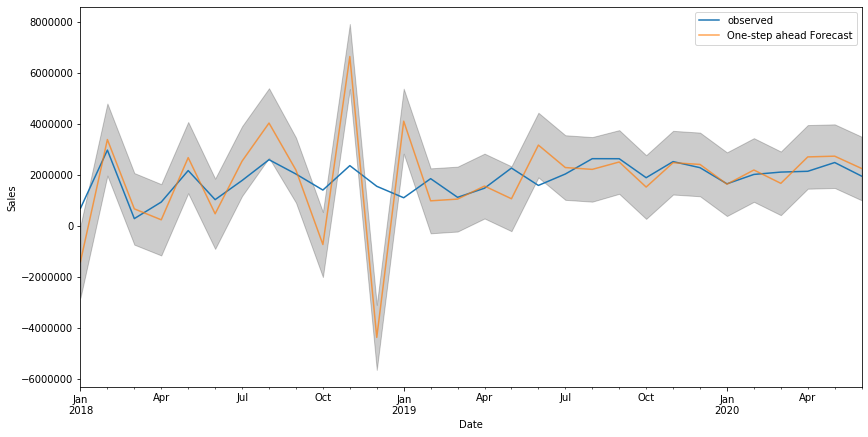

In [42]:
#Checking how good the model is by comparing the observed versus the forecast
ax = ts['2018':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show();

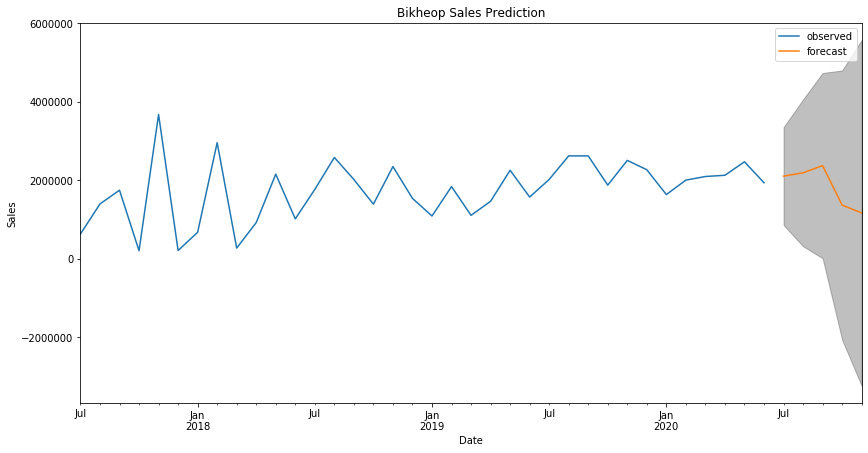

In [44]:
#Giving the final prediction as a plot
pred_uc = results.get_forecast(steps=5)
pred_ci = pred_uc.conf_int()

ax = ts.plot(label='observed', figsize=(14, 7))

pred_uc.predicted_mean.plot(ax=ax, label='forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.set_title('Bikheop Sales Prediction')

plt.legend()
plt.show();